##CPI Stack 

This code will have the preprocess and model code run on all the benchmarks at a time. The data obtained will be used to graph cpi stack.

In [ ]:

# Preprocess libraries used
import pandas as pd
import numpy as np
import seaborn as sb
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt 

# Model libraries used
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Lasso
import statsmodels.api as sm
from math import sqrt
import yaml


information = {}

with open('../yaml/information.yaml') as f:
    information = yaml.load(f)


filenames = information['benchmarks']

events = {'base': []}


for filename in filenames:

  input_filename = filename + '.txt'

  data_txt = pd.read_csv(input_filename, sep="\t")
  dataset_columns = set()
  timewise_data = {}

  ignored_time = []   # add time whose data you want to skip

  for index, row in data_txt.iterrows():

    if row[0].find('time') != -1:
      continue

    ignore = 0
    for time in ignored_time:
      if time in row[0]:
        ignore = 1
        break

    if ignore:
      continue

    current_time_data = []
    extract = ""

    for i in range(len(row[0])):
      if row[0][i] not in [' ', ',']:
        extract += row[0][i]
      if row[0][i] == ' ' and extract != "":
        current_time_data.append(extract)
        extract = ""

    current_time_data[2] = current_time_data[2].split(':')[0]
    dataset_columns.add(current_time_data[2])
    if not timewise_data.get(current_time_data[0]):
      timewise_data[current_time_data[0]] = []
    timewise_data[current_time_data[0]].append([current_time_data[2], current_time_data[1]])

  dataset = {}
  dataset['time'] = []

  for column in dataset_columns:
    dataset[column] = []

  cpi_possible = 0
  if "instructions" in dataset_columns and "cycles" in dataset_columns:
    dataset['cpi'] = []
    cpi_possible = 1
  else:
    print("cpi does not exist")

  token = {}    # token for only one time addition of event for a  particular time

  for column in dataset_columns:
    token[column] = 1

  for key, val in timewise_data.items():

    for column in dataset_columns:
      token[column] = 1

    dataset['time'].append(key)
    instruction = 0
    cycle = 0

    for event in val:

      if event[0] == "instructions":
        instruction = event[1]
      if event[0] == "cycles":
        cycle = event[1]

    for event in val:
        
      if token[event[0]]:
          
        event_count_per_instruction = float(event[1])/float(instruction)
        dataset[event[0]].append(event_count_per_instruction)

      token[event[0]] = 0

    if cpi_possible:

      cpi = float(cycle)/float(instruction)
      dataset["cpi"].append(cpi)

  dataset = pd.DataFrame.from_dict(dataset)

  # removing outliers
  dataset = dataset[~(dataset['cpi'] > 2)]

  columns_means_values = dict(dataset.describe(include='all').loc['mean'])


  dataset_columns = list(dataset.columns)
  dataset_columns = dataset_columns[2:]

  events_remove_from_dataset = ['instructions','cycles']
  for event in events_remove_from_dataset:
    dataset_columns.remove(event)

  cpi = dataset['cpi']

  updated_dataset = dataset[dataset_columns[:-1]]
  updated_dataset.columns = dataset_columns[:-1]

  X = updated_dataset
  y = cpi

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.167)

  regressor = Lasso(alpha=0.00001,positive=True,selection='random',normalize=True,max_iter=1000000)
  reg = regressor.fit(X_train, y_train)


  y_pred = reg.predict(X_test)


  rmse = sqrt(mean_squared_error(y_test, y_pred))
  y1 = regressor.predict(X_train)
  rsq = r2_score(y_train,y1) #R-Squared on the training data
  rad = 1-(((1-rsq)*(len(y_train)-1))/(len(y_train)-1-X_train.shape[1]))
  res = y_test-y_pred
  F = (rsq/(1-rsq))*((len(y_test)-1-X_test.shape[1])/X_test.shape[1])
  regressor.score(X,y)

  residual_average = 0.0
  for i in range(len(res)):
    residual_average += abs(res.iloc[i])

  residual_average = residual_average/len(res)

  reg2 = sm.OLS(y_train, X_train).fit()


  dataset_columns = updated_dataset.columns

  coeff = {}
  ind = 0

  for column in dataset_columns:

    if not events.get(column):
      events[column] = []
  
    coeff[column] = reg.coef_[ind]
    ind += 1

  b0 = reg.intercept_
  events['base'].append(b0)

  cpi_cal = b0

  for column in dataset_columns:
    cpi_cal += (coeff[column] * columns_means_values[column])
    events[column].append(coeff[column] * columns_means_values[column])



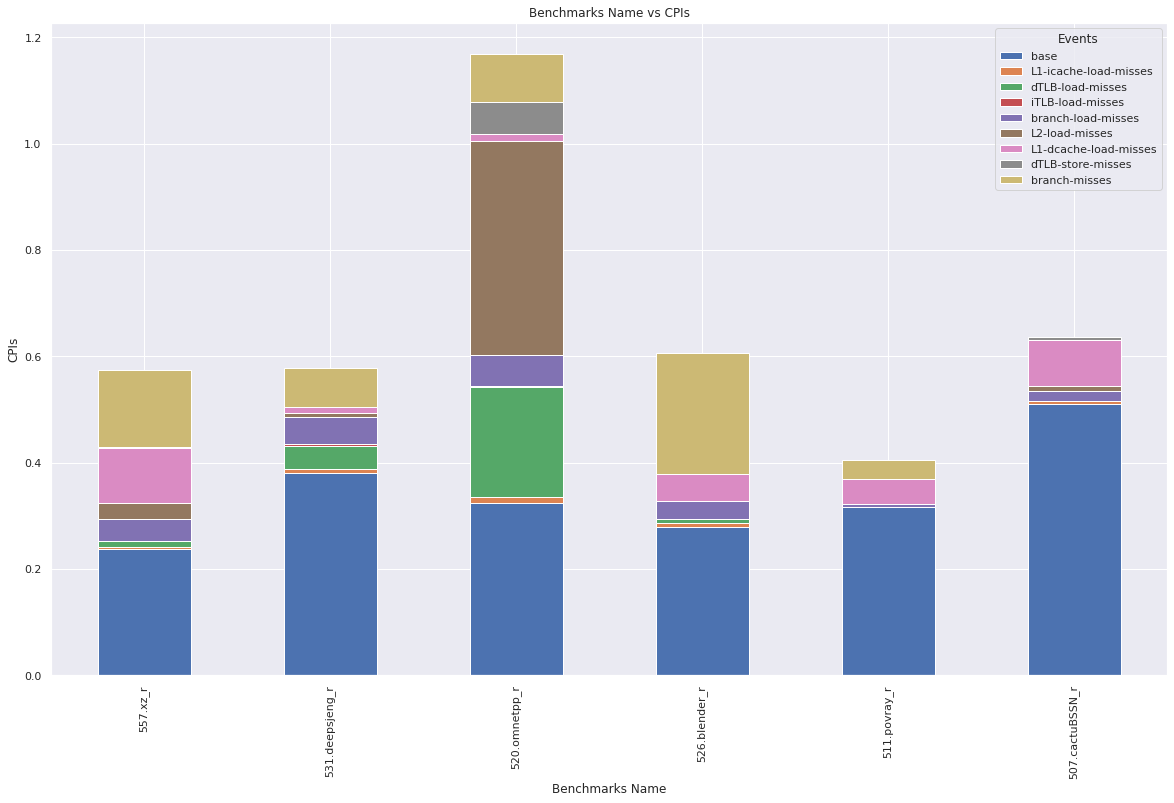

In [ ]:
columns=["Events"] + information['benchmarks']
data = []
for e in events:
  lst = [e]
  lst.extend(events[e])
  data.append(lst)

# print(data)
events_df = pd.DataFrame(columns=columns, data=data)
events_df
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(20,12)})
fig = events_df.set_index("Events").T.plot(kind='bar', stacked=True)
plt.xlabel("Benchmarks")
plt.ylabel("CPIs")
plt.title("Benchmarks vs CPIs") # You can comment this line out if you don't need title
plt.show(fig)